# NBA All-Time Playoff Scoring Ranks

In [20]:
import pandas as pd
from nba_api.stats.endpoints import commonallplayers
from nba_api.stats.endpoints import playercareerstats
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import mplcursors
pd.set_option('display.max_columns', None)

In [21]:
player_data = commonallplayers.CommonAllPlayers(timeout = 30)  # API Call
player_df = player_data.common_all_players.get_data_frame().set_index('PERSON_ID') # DataFrame containing player info

In [22]:
player_df.head(10)

,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
PERSON_ID,,,,,,,,,,,,,
76001,"Abdelnaby, Alaa",Alaa Abdelnaby,0,1990,1994,HISTADD_alaa_abdelnaby,0,,,,,Y,00
76002,"Abdul-Aziz, Zaid",Zaid Abdul-Aziz,0,1968,1977,HISTADD_zaid_abdul-aziz,0,,,,,Y,00
76003,"Abdul-Jabbar, Kareem",Kareem Abdul-Jabbar,0,1969,1988,HISTADD_kareem_abdul-jabbar,0,,,,,Y,00
51,"Abdul-Rauf, Mahmoud",Mahmoud Abdul-Rauf,0,1990,2000,mahmoud_abdul-rauf,0,,,,,Y,00
1505,"Abdul-Wahad, Tariq",Tariq Abdul-Wahad,0,1997,2003,tariq_abdul-wahad,0,,,,,Y,00
949,"Abdur-Rahim, Shareef",Shareef Abdur-Rahim,0,1996,2007,shareef_abdur-rahim,0,,,,,Y,00
76005,"Abernethy, Tom",Tom Abernethy,0,1976,1980,HISTADD_tom_abernethy,0,,,,,Y,00
76006,"Able, Forest",Forest Able,0,1956,1956,HISTADD_frosty_able,0,,,,,Y,00
76007,"Abramovic, John",John Abramovic,0,1946,1947,HISTADD_brooms_abramovic,0,,,,,Y,00


In [23]:
id_list = player_df.index.tolist() # Making list 'id_list' containing PERSON_ID index from DataFrame 'player_df'

In [24]:
"""
Generator 'playoff_stats' which yields the number of Playoff Games Played (GP) and Career Playoff Points (PTS)
as a list scored by every NBA player who has ever played in an NBA playoff game.
"""

def playoff_stats(player_id):

    player_stats = playercareerstats.PlayerCareerStats(player_id, timeout = 30)
    
    yield player_stats.career_totals_post_season.get_data_frame()[['GP', 'PTS']].values.tolist()

In [ ]:
stats_dict = {} # New dictionary which will contain player name and their playoff GP and PTS stats

for i in id_list: # Looping through our 'id_list' list
    
    try:
        stats_call = next(playoff_stats(i)) # Calling the generator with the player's ID as the 'player_id' variable
        
        if len(stats_call) > 0:
            stats_dict[player_df.loc[i]['DISPLAY_FIRST_LAST']] = [stats_call[0][0], stats_call[0][1]]
            # Adding their playoff GP and PTS to the 'stats_dict' dictionary
        
    except KeyError: # Not every player in NBA history has played in a playoff game.  For those who haven't, our
        continue     # generator will have nothing to yield and we will get a KeyError.  So we continue.

In [26]:
# Creating a DataFrame from our 'stats_dict' dictionary
playoff_data_DF = pd.DataFrame.from_dict(stats_dict, orient = 'index')

# Resetting the index and naming new columns in order to edit the data for our graph cursor (more below)
playoff_data_DF.rename(columns={0: 'Playoff Games Played', 1: 'Playoff Points Scored'}, inplace = True)
playoff_data_DF.reset_index(inplace = True)
playoff_data_DF.rename(columns={'index': 'Player Name'}, inplace = True)
playoff_data_DF['Player Name (Graph Info)'] = playoff_data_DF['Player Name']

In [27]:
"""
All of the code in this cell is used to make the 'caption' more descriptive when you hover the mouse over a
certain point on the graph.

Rather than just saying the name of the player, it also includes their playoff scoring rank as well as their 
total playoff points scored.
"""

# Making our Playoff Points Scored column from the DataFrame into a list titled 'pts'
pts = playoff_data_DF['Playoff Points Scored'].tolist()

# Ranking the top scorers (while maintaining the indexes of list 'pts') to a new list titled 'rank_list'
rank_pts = [1] * len(pts)
for i, x in enumerate(sorted(range(len(pts)), key=lambda y: pts[y])):
    rank_pts[x] = i

scoring_rank = [abs(len(rank_pts) - i) for i in rank_pts]

# Adding each players scoring rank and total points to their 'Player Name' column in our DataFrame so that 
# they will show up when we hover our mouse over the scatter plot
ct = 0

for i in playoff_data_DF.index:
    
    playoff_data_DF.loc[i, 'Player Name (Graph Info)'] = str(scoring_rank[ct]) + '. ' + playoff_data_DF.loc[i]['Player Name (Graph Info)'] + ' - ' + playoff_data_DF.loc[i]['Playoff Points Scored'].astype(str) + ' pts'
    
    ct += 1

# Reset index
playoff_data_DF.reset_index(drop=True, inplace = True)

<IPython.core.display.Javascript object>


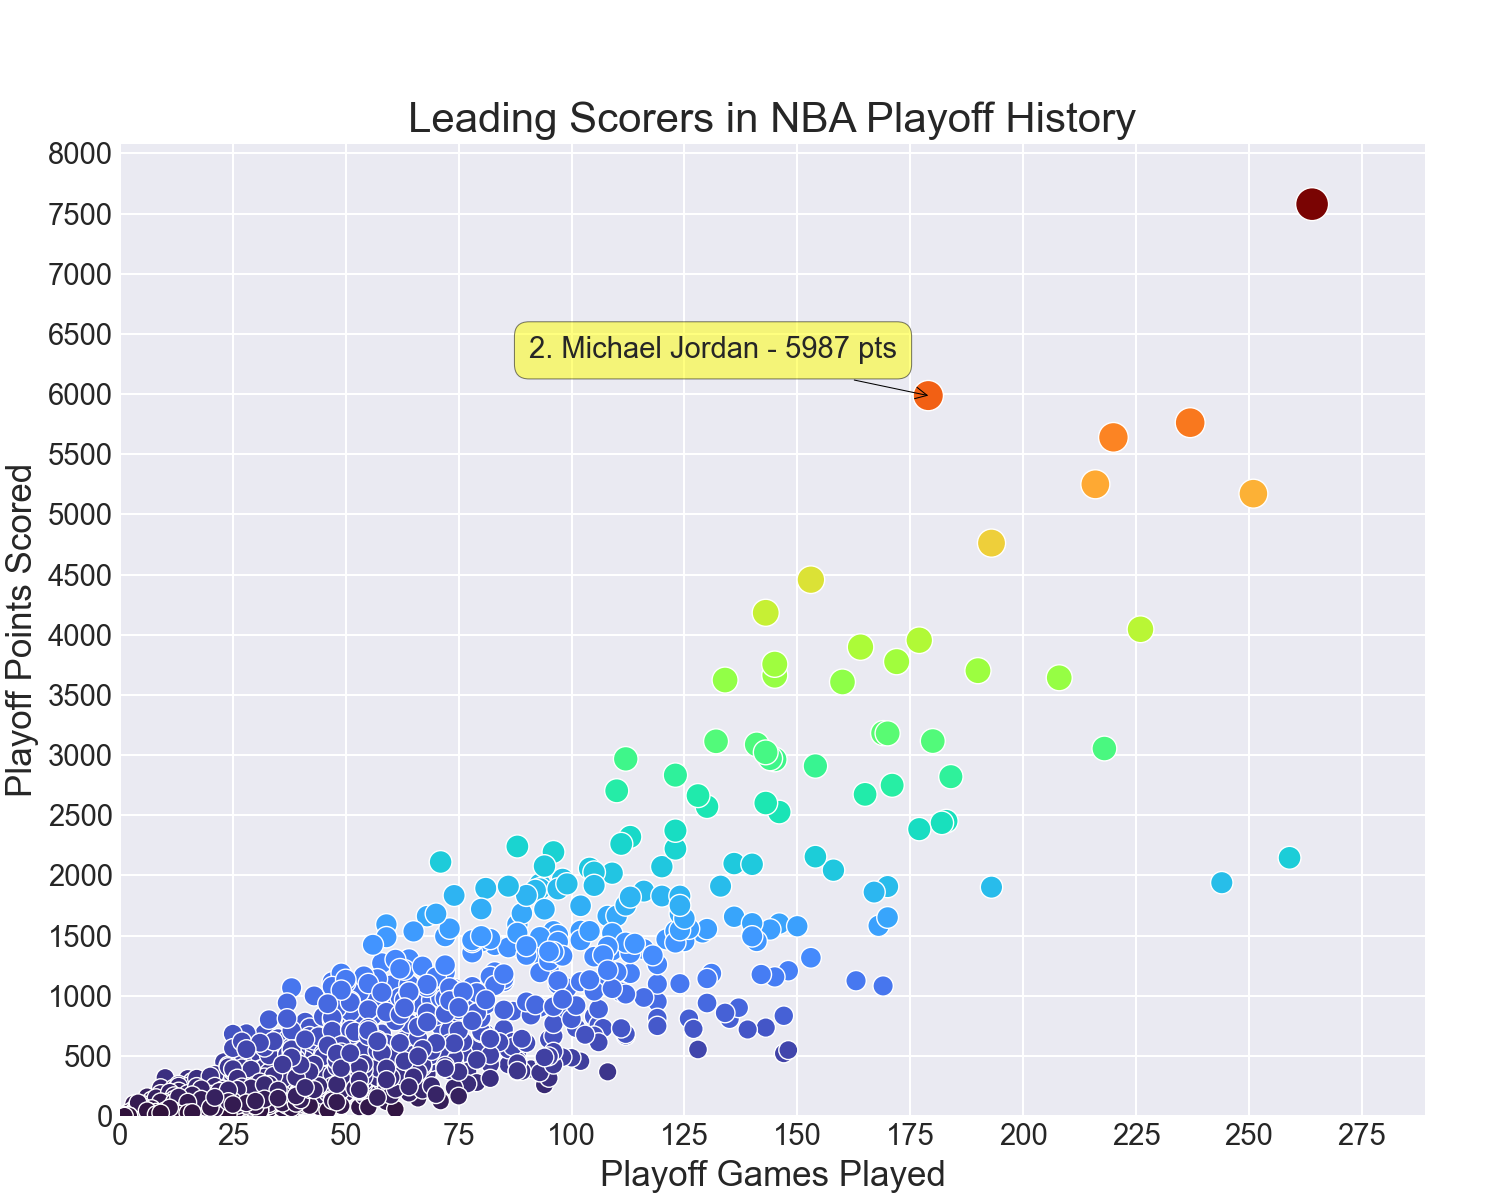

In [42]:
"""
We use this magic command below to create an interactive plot within Jupyter.
"""
%matplotlib notebook

# Styling scatter plot
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data = playoff_data_DF, x = 'Playoff Games Played', y = 'Playoff Points Scored', hue = 'Playoff Points Scored',
    palette = 'turbo', size = 'Playoff Points Scored', sizes = (70, 250), legend = False)

plt.xticks(np.arange(0, playoff_data_DF['Playoff Games Played'].max() + 50, 25))
plt.yticks(np.arange(0, playoff_data_DF['Playoff Points Scored'].max() + 1000, 500))
plt.title('Leading Scorers in NBA Playoff History')

plt.xlim(0, playoff_data_DF['Playoff Games Played'].max() + 25)
plt.ylim(0, playoff_data_DF['Playoff Points Scored'].max() + 500)

"""
I found the following lambda function online and modified it to show the index value when you hover over a
point rather than the x,y coordinates.  This way, whenever you hover over a point in the live graph below it will
tell you which player that point represents.
"""

mplcursors.cursor().connect(
    "add", lambda sel: sel.annotation.set_text(playoff_data_DF['Player Name (Graph Info)'][sel.target.index]))

plt.show()

> ### When we click a point on the graph we will see the player's name, their rank on the all-time playoff scoring list, and their total number of playoff points

<IPython.core.display.Javascript object>


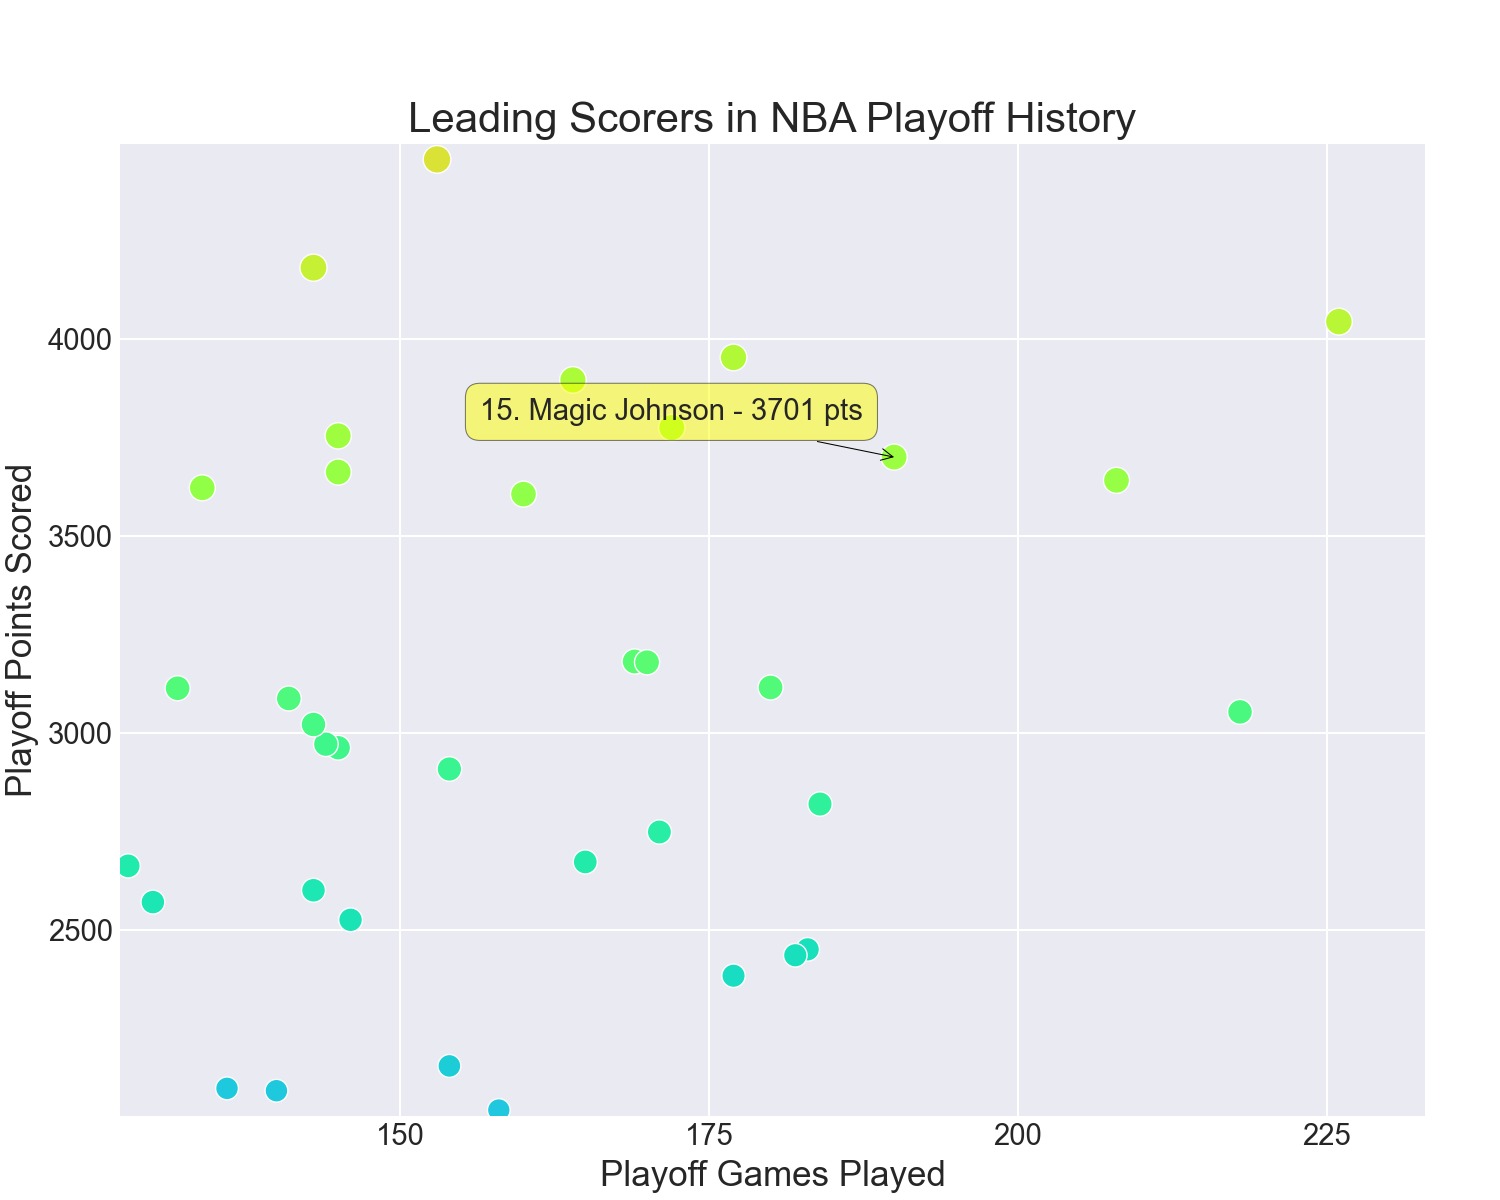

In [43]:
# Styling scatter plot
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data = playoff_data_DF, x = 'Playoff Games Played', y = 'Playoff Points Scored', hue = 'Playoff Points Scored',
    palette = 'turbo', size = 'Playoff Points Scored', sizes = (70, 250), legend = False)

plt.xticks(np.arange(0, playoff_data_DF['Playoff Games Played'].max() + 50, 25))
plt.yticks(np.arange(0, playoff_data_DF['Playoff Points Scored'].max() + 1000, 500))
plt.title('Leading Scorers in NBA Playoff History')

plt.xlim(0, playoff_data_DF['Playoff Games Played'].max() + 25)
plt.ylim(0, playoff_data_DF['Playoff Points Scored'].max() + 500)

"""
I found the following lambda function online and modified it to show the index value when you hover over a
point rather than the x,y coordinates.  This way, whenever you hover over a point in the live graph below it will
tell you which player that point represents.
"""

mplcursors.cursor().connect(
    "add", lambda sel: sel.annotation.set_text(playoff_data_DF['Player Name (Graph Info)'][sel.target.index]))

plt.show()

> ### Here we've called the exact same graph, but used the manual 'zoom' function on the interactive notebook.  This allows us to get a better view of the dense clusters of points.  Even zoomed in, our cursor still works to identify our basketball players.

In [32]:
playoff_data_DF

,Player Name,Playoff Games Played,Playoff Points Scored,Player Name (Graph Info)
0,Alaa Abdelnaby,17,38,1672. Alaa Abdelnaby - 38 pts
1,Zaid Abdul-Aziz,18,92,1285. Zaid Abdul-Aziz - 92 pts
2,Kareem Abdul-Jabbar,237,5762,3. Kareem Abdul-Jabbar - 5762 pts
3,Mahmoud Abdul-Rauf,15,195,925. Mahmoud Abdul-Rauf - 195 pts
4,Tariq Abdul-Wahad,13,68,1423. Tariq Abdul-Wahad - 68 pts
...,...,...,...,...
2723,Wang Zhi-zhi,16,30,1745. Wang Zhi-zhi - 30 pts
2724,Paul Zipser,6,44,1596. Paul Zipser - 44 pts
2725,Ante Zizic,8,13,2009. Ante Zizic - 13 pts
2726,Ivica Zubac,21,155,1052. Ivica Zubac - 155 pts
